In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
%matplotlib inline

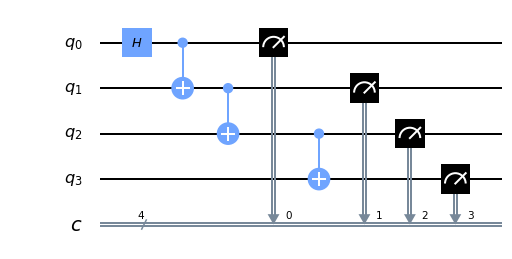

In [2]:
nqubits = 4
q = QuantumRegister(nqubits,name='q')
c = ClassicalRegister(nqubits,name='c')
circuit = QuantumCircuit(q,c,name='circuit')
circuit.h(0)
for ii in (range(nqubits-1)):
    circuit.cx(ii,ii+1)
    
circuit.measure(range(nqubits),range(nqubits))
circuit.draw(output='mpl')

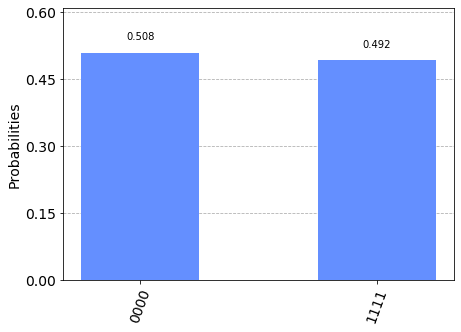

In [3]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit,backend=simulator,shots=1024).result()
plot_histogram(sim_result.get_counts(circuit))

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')
job = execute(circuit, backend = device, shots=1024)
print(job.job_id())
job_monitor(job)

5e9ba73a3b956500180d86ec
Job Status: job has successfully run


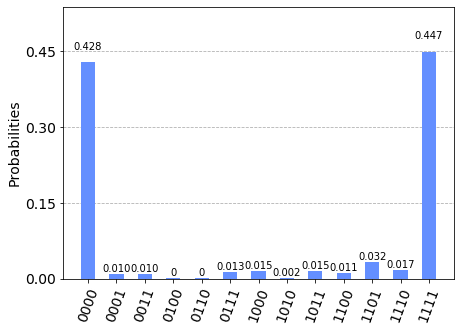

In [5]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

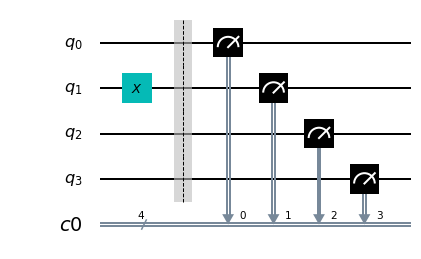

In [6]:
qr = QuantumRegister(nqubits,'qreg')
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')
cal_circuits[2].draw(output='mpl')

In [7]:
print(len(cal_circuits))
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

16
5e9ba78df9bae90018f3517b
Job Status: job has successfully run


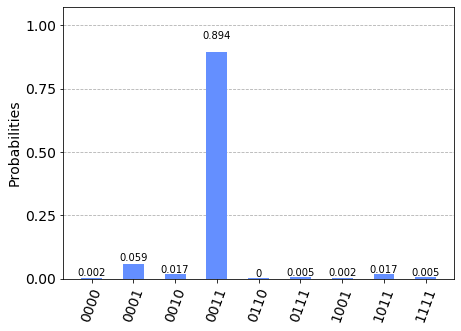

In [8]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

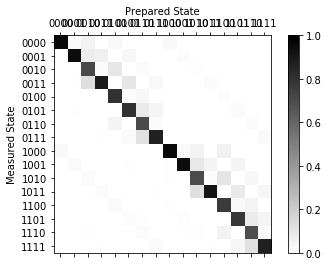

In [9]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

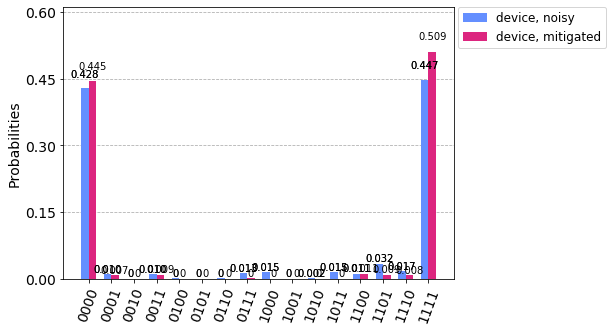

In [10]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy','device, mitigated'])

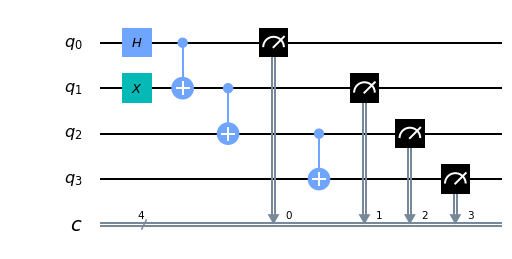

In [11]:
q = QuantumRegister(nqubits,name='q')
c = ClassicalRegister(nqubits,name='c')
circuit2 = QuantumCircuit(q,c,name='circuit')
circuit2.x(1)
circuit2.h(0)
for ii in (range(nqubits-1)):
    circuit2.cx(ii,ii+1)
circuit2.measure(range(nqubits),range(nqubits))
circuit2.draw(output='mpl')

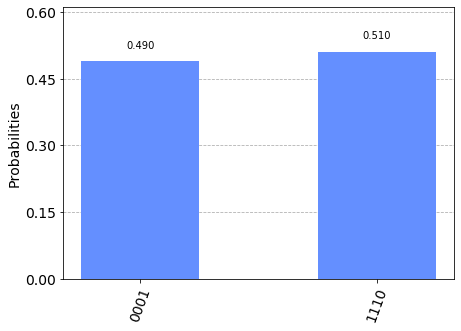

In [12]:
plot_histogram(
    execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
)

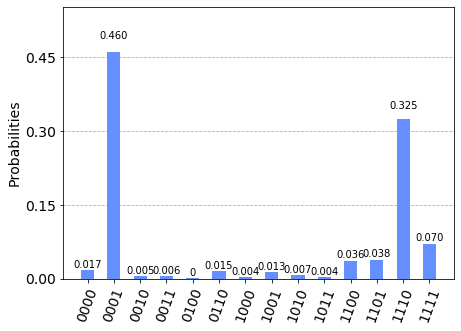

In [13]:
device_counts2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)
plot_histogram(device_counts2)

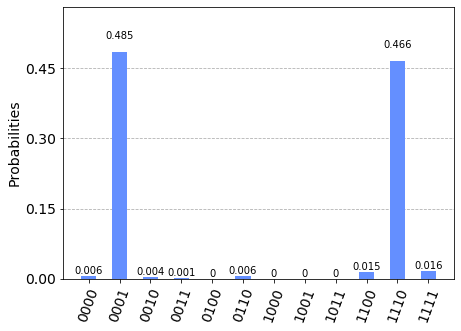

In [14]:
device_mitigated_counts2 = meas_filter.apply(device_counts2)
plot_histogram(device_mitigated_counts2)